# Task 1. Playing with YoLO (from torch.hub)

In this task, you will download pre-trained weights for the YOLOv5 model and use it to detect objects in an image.
You will use the `torch.hub` library to download the model and weights. The model is trained on the COCO dataset, which contains 80 classes of objects.

## Introduction to YoLOv5

### Installation
You need to install OpenCV and PyTorch. You can do this using pip:
```bash
pip install opencv-python torch torchvision
```

### Additional dependencies
In case you have any errors related to OpenCV (missing libgl1.so.1), you may need to install additional dependencies. You can do this using the following command:
```bash
sudo apt install libgl1-mesa-glx libgl1 libglib2.0-0
```

### Downloading the model

In [1]:
import torch
from PIL import Image
import requests
from io import BytesIO


In [2]:
# Download YoLOv5 weights
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)
yolo_model.eval()

print("YOLOv5 model loaded and ready to use.")

Using cache found in C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-5 Python-3.12.6 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded and ready to use.


### Inference

💡 ProTip: Input images are automatically transferred to the correct model device before inference.

In [3]:
image_url = "https://ultralytics.com/images/zidane.jpg"

results = yolo_model(image_url)

C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


image 1/1: 720x1280 2 persons, 1 tie, 1 cell phone
Speed: 1248.4ms pre-process, 173.1ms inference, 2.0ms NMS per image at shape (1, 3, 384, 640)


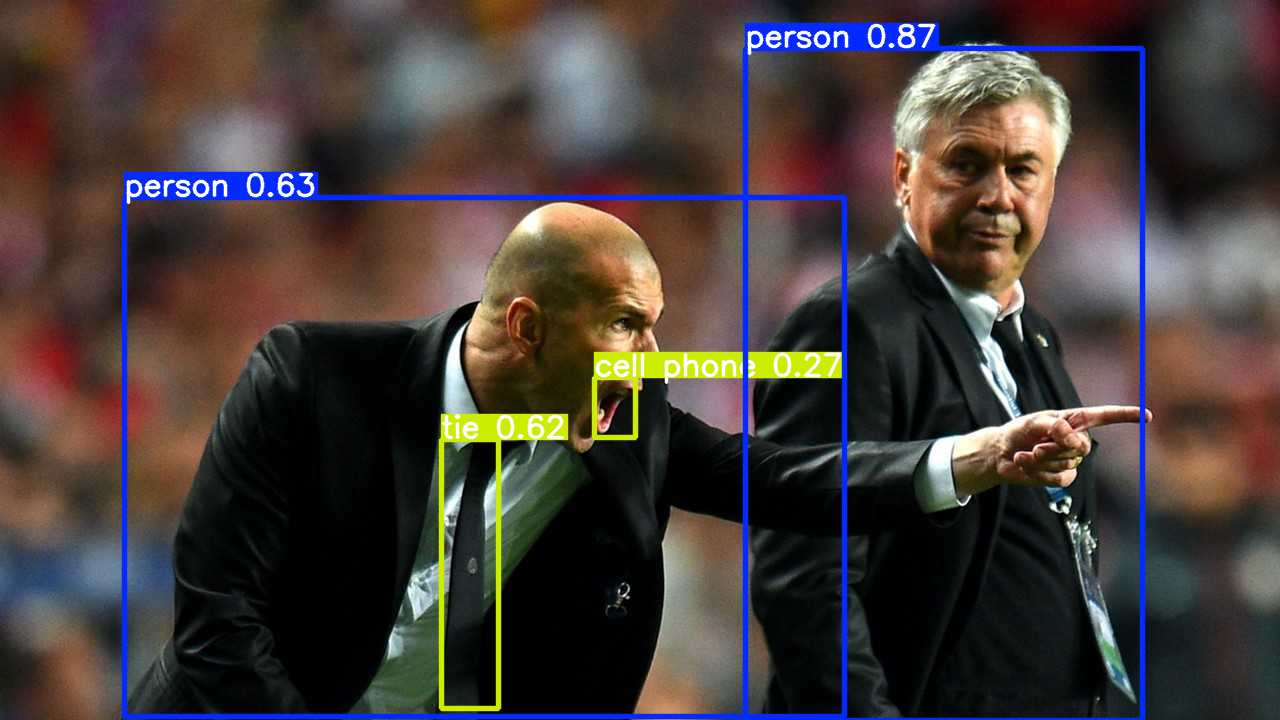

In [4]:
results.print()  # Print results to console
results.show()   # Display results in a window

In [5]:
results.xyxy # Get predictions in xyxy format

[tensor([[7.45579e+02, 4.84703e+01, 1.14269e+03, 7.20000e+02, 8.68910e-01, 0.00000e+00],
         [1.24744e+02, 1.97335e+02, 8.44397e+02, 7.16651e+02, 6.30325e-01, 0.00000e+00],
         [4.41239e+02, 4.39351e+02, 4.98381e+02, 7.08571e+02, 6.16793e-01, 2.70000e+01],
         [5.94082e+02, 3.77300e+02, 6.35424e+02, 4.37148e+02, 2.74013e-01, 6.70000e+01]])]

In [6]:
results.xywhn[0]        # Get predictions in xywhn format
results.pandas().xywhn  # Get predictions in pandas DataFrame format

[    xcenter   ycenter     width    height  confidence  class        name
 0  0.737607  0.533660  0.310247  0.932680    0.868910      0      person
 1  0.378571  0.634712  0.562229  0.721272    0.630325      0      person
 2  0.367039  0.797168  0.044642  0.373917    0.616793     27         tie
 3  0.480276  0.565589  0.032298  0.083121    0.274013     67  cell phone]

## Raw predictions

Above, you have already gotten the results after applying Non-Max Suppression (NMS) and thresholding.
The model outputs a list of predictions, which are the bounding boxes (bboxes) around the detected objects.

In this task, you will visualize the raw predictions and implement the NMS and thresholding yourself.

In [7]:
# Here are some additional attributes you can check for the YOLOv5 model
print(yolo_model.conf) # NMS confidence threshold
print(yolo_model.iou)  # NMS IoU threshold

0.25
0.45


Below is the code to load the image into tensor and run `yolo_model.model(image_tensor)` to get the raw predictions.

This will give you a tensor of shape `(1, num_boxes, 85)`, where `num_boxes` is the number of detected boxes and 85 is the number as follows: 4 coordinates of the box, 1 objectness score, and 80 class scores.

In [8]:
import numpy as np
import cv2

response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image_np = np.array(image)  # Convert PIL image to NumPy array

# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im

img_letterboxed = letterbox(image_np)
img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0  # HWC → CHW and normalize
img_tensor = img_tensor.unsqueeze(0).to(device)

# Inference without NMS
with torch.no_grad():
    raw_preds = yolo_model.model(img_tensor)  # tensor of shape [1, 25200, 85]

print("Raw prediction shape:", raw_preds.shape)

Raw prediction shape: torch.Size([1, 25200, 85])


# Setup

## Imports

In [9]:
%matplotlib inline

In [10]:
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm


# Solution

### 1
(**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?

Output tensor has size of 85 - it consiste of 4 coordinates of the bounding box, 1 objectness score and 80 class scores.  

The objectness score is a measure of how likely it is that an object is present in the bounding box. It is calculated as the product of the class scores and the confidence score of the bounding box.  
The class scores are the probabilities of each class being present in the bounding box, and the confidence score is a measure of how confident the model is that the bounding box contains an object.  
The objectness score is used to filter out low-confidence detections and keep only high-confidence ones.

### 2
**1p**  Implement the NMS and thresholding yourself.

In [11]:
def xywh2xyxy(x):
    # convert [x_center, y_center, w, h] to [x1, y1, x2, y2]
    y = x.clone() if isinstance(x, torch.Tensor) else torch.tensor(x)
    y = y.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # x1
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # y1
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # x2
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # y2
    return y

In [12]:
def box_iou(box1, box2):
    # calc IoU between two sets of boxes
    # box1: [N, 4], box2: [M, 4]

    # intersection
    # top left corner
    inter_x1 = torch.max(box1[:, None, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, None, 1], box2[:, 1])

    # bottom right corner
    inter_x2 = torch.min(box1[:, None, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, None, 3], box2[:, 3])

    inter_w = (inter_x2 - inter_x1).clamp(0)
    inter_h = (inter_y2 - inter_y1).clamp(0)
    
    inter = inter_w * inter_h

    # union
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1[:, None] + area2 - inter

    return inter / union  # [N, M]

In [13]:
def non_max_suppression(predictions, conf_thresh=0.25, iou_thresh=0.5, max_detections=300):
    # Applies Non-Maximum Suppression (NMS) on inference results
    # predictions: torch.Tensor of shape [batch, num_preds, 85]
    # Returns list of detections per image [[x1,y1,x2,y2,conf,cls],...]
    output = []

    for preds in predictions:  # process each image
        # Compute confidence and filter
        conf = preds[:, 4]
        cls_scores, cls_inds = preds[:, 5:].max(1)
        confidences = conf * cls_scores
        mask = confidences > conf_thresh
        preds = preds[mask]
        confidences = confidences[mask]
        cls_inds = cls_inds[mask]

        # If none remain, add empty
        if not preds.size(0):
            output.append(torch.empty((0, 6)))
            continue

        # Convert boxes to xyxy
        boxes = xywh2xyxy(preds[:, :4])

        # Stack boxes, confidences, class
        dets = torch.cat((boxes, confidences.unsqueeze(1), cls_inds.float().unsqueeze(1)), dim=1)

        # Sort by confidence descending
        dets = dets[dets[:, 4].argsort(descending=True)]

        # Apply NMS
        keep = []
        while dets.size(0) and len(keep) < max_detections:
            # Select top det and remove it
            top = dets[0]
            keep.append(top)
            if dets.size(0) == 1:
                break
            # Compute IoU of the top with rest
            ious = box_iou(top[:4].unsqueeze(0), dets[:, :4])[0]
            # Keep boxes with IoU below threshold or different class
            mask = (ious < iou_thresh) | (dets[:, 5] != top[5])
            dets = dets[mask]

        output.append(torch.stack(keep) if keep else torch.empty((0, 6)))
        
    return output

### 3
**1p**  Visualize the raw predictions and the predictions after NMS and thresholding.

In [14]:
# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1]) # ratio (new / old)
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r))) # new unpadded size
    dw = new_shape[1] - new_unpad[0] # width padding (left + right)
    dh = new_shape[0] - new_unpad[1] # height padding (top + bottom)
    dw /= 2 # divide padding into 2 sides
    dh /= 2 # divide padding into 2 sides
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR) # resize
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1)) # add padding to top and bottom
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1)) # add padding to left and right
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color) # add border
    return im

def get_raw(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image_np = np.array(image)  # Convert PIL image to NumPy array

    img_letterboxed = letterbox(image_np)
    img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0  # HWC → CHW and normalize
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Inference without NMS
    with torch.no_grad():
        raw_preds = yolo_model.model(img_tensor)  # tensor of shape [1, 25200, 85]

    return raw_preds

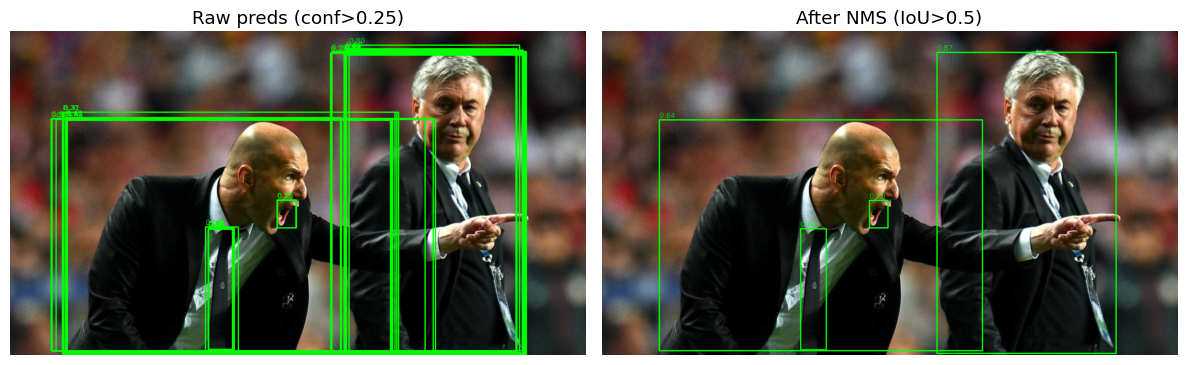

In [15]:
# Download and get image
URL = "https://ultralytics.com/images/zidane.jpg"
resp = requests.get(URL)
orig = np.array(Image.open(BytesIO(resp.content)).convert("RGB"))
h0, w0 = orig.shape[:2]

raw_preds = get_raw(URL)

# Rescale boxes from padded image to original image
def scale_coords_pad(boxes, old_size, new_size = (640, 640)):
    h0, w0 = old_size # original image size

    # calculate ratio and new unpadded size
    r = min(new_size[0] / h0, new_size[1] / w0) # ratio (new / old)
    new_unpad = (int(w0 * r), int(h0 * r)) # new unpadded size
    dw, dh = (new_size[1] - new_unpad[0]) / 2, (new_size[0] - new_unpad[1]) / 2 # padding (left + right, top + bottom)

    # remove padding
    boxes[:, [0,2]] -= dw
    boxes[:, [1,3]] -= dh
    # then scale back
    boxes[:, :4] /= r
    # clip to original
    boxes[:, 0].clamp_(0, w0) # x1
    boxes[:, 1].clamp_(0, h0) # y1
    return boxes


# Prepare raw & NMS predictions (as before)
CONF = 0.25
IOU = 0.5
preds = raw_preds[0] # extract first image predictions
obj = preds[:, 4] # objectness score

# Filter by confidence threshold
cls_conf, cls_id = preds[:, 5:].max(1) # class confidence
scores = obj * cls_conf # compute final score
mask = scores > CONF # create mask for filtering
raw_boxes_xywh = preds[mask, :4] # filter boxes and keep their xywh format
raw_scores = scores[mask] # filter and keep scores
raw_boxes = xywh2xyxy(raw_boxes_xywh) # convert to xyxy on padded
raw_boxes = scale_coords_pad(raw_boxes, (h0, w0)) # rescale to original image

# NMS output
dets_nms = non_max_suppression(raw_preds, conf_thresh=CONF, iou_thresh=IOU)
out = dets_nms[0] if dets_nms and dets_nms[0].numel() else torch.empty((0,6)) # empty if no detections
nms_boxes = out[:, :4].clone() # xyxy format
nms_scores = out[:, 4] # confidence score
nms_boxes = scale_coords_pad(nms_boxes, (h0, w0)) # rescale to original image

# Draw and plot
def draw_boxes(img, boxes, confs=None):
    im = img.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,0), 2)
        if confs is not None:
            cv2.putText(im, f"{confs[i]:.2f}", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return im

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(draw_boxes(orig, raw_boxes, raw_scores))
axes[0].set_title(f"Raw preds (conf>{CONF})")
axes[0].axis("off")

axes[1].imshow(draw_boxes(orig, nms_boxes, nms_scores))
axes[1].set_title(f"After NMS (IoU>{IOU})")
axes[1].axis("off")

plt.tight_layout()
plt.show()


### 4
(**0.25p**) Compare the results with the original predictions.

they are the same

### 5
(**0.5p**) Vary IoU threshold for NMS and show its effect on detections.

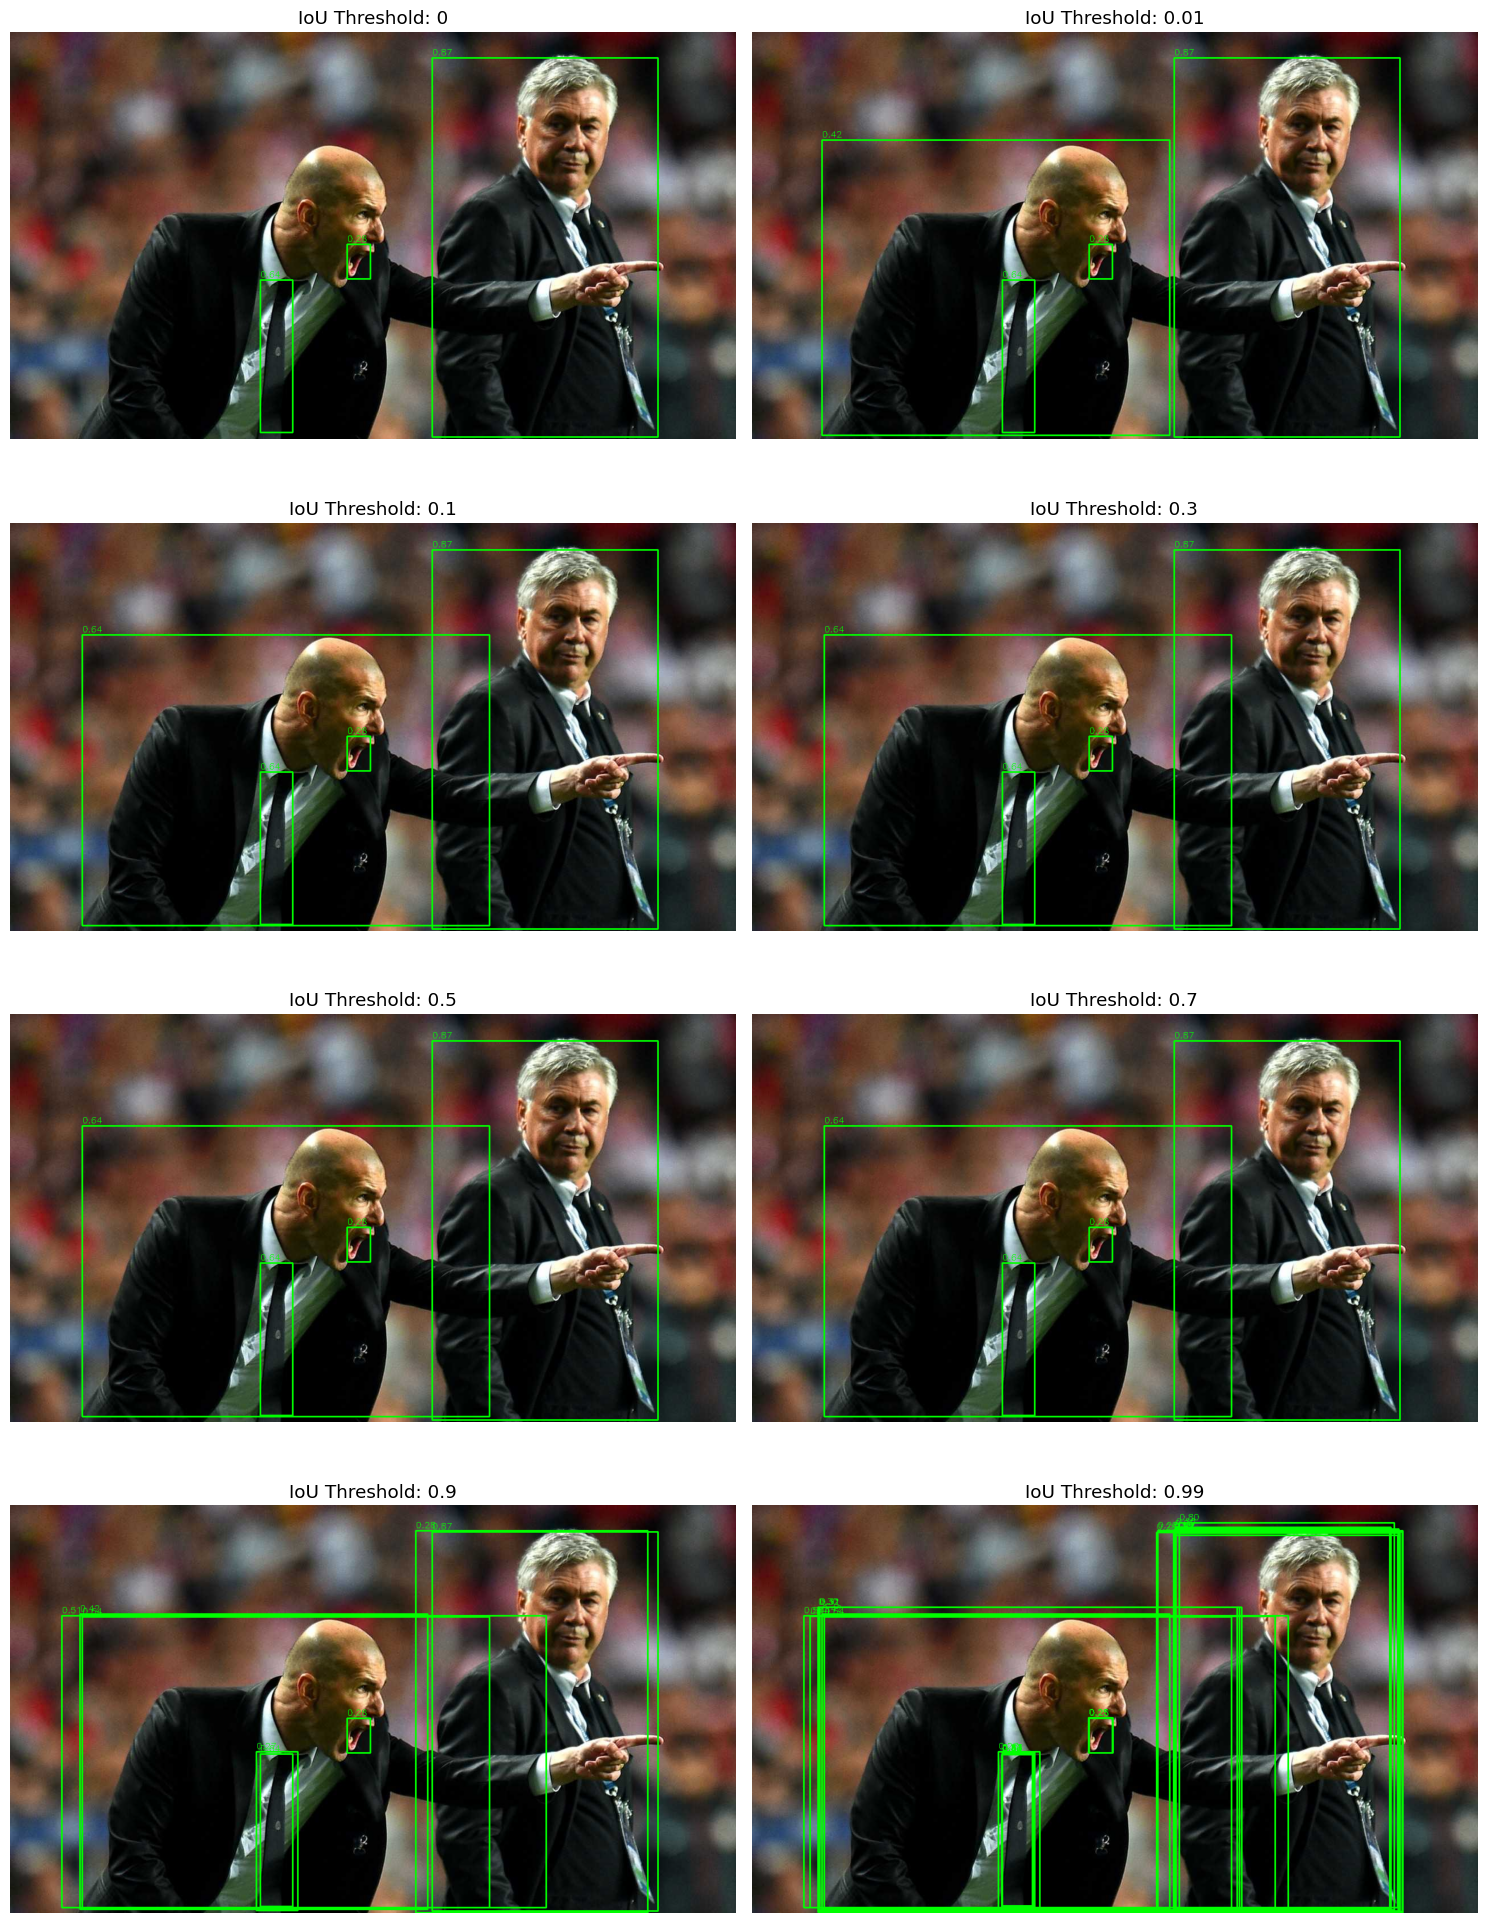

In [17]:
iou_thresholds_to_test = [0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
max_images_per_row = 2
num_rows = (len(iou_thresholds_to_test) + max_images_per_row - 1) // max_images_per_row

fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, iou_thresh in enumerate(iou_thresholds_to_test):
    # Apply NMS with the current IoU threshold
    dets_nms_varied = non_max_suppression(raw_preds, conf_thresh=0.25, iou_thresh=iou_thresh)
    out_varied = dets_nms_varied[0] if dets_nms_varied and dets_nms_varied[0].numel() else torch.empty((0, 6))
    nms_boxes_varied = out_varied[:, :4].clone()
    nms_scores_varied = out_varied[:, 4]
    nms_boxes_varied = scale_coords_pad(nms_boxes_varied, (h0, w0))

    # Draw the boxes on the image
    img_with_boxes = draw_boxes(orig, nms_boxes_varied, nms_scores_varied)

    # Plot the results
    axes[i].imshow(img_with_boxes)
    axes[i].set_title(f"IoU Threshold: {iou_thresh}")
    axes[i].axis("off")

# Hide any unused subplots
for j in range(len(iou_thresholds_to_test), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### 6
(**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision

In [22]:
def match_predictions_to_ground_truth(pred_boxes, pred_scores, pred_labels,
                                      gt_boxes, gt_labels,
                                      iou_threshold):
    # Matches predicted boxes to ground-truth boxes at a given IoU threshold
    # Returns lists of matches: true positives (TP), false positives (FP), and false negatives (FN)
    
    # sort by descending score
    order = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[order]
    pred_labels = pred_labels[order]

    TP = 0
    FP = 0
    matched_gt = set()

    # for each prediction, see if it matches any unmatched GT of same class
    for pb, pl in zip(pred_boxes, pred_labels):
        # filter GTs of same class
        same_cls = [i for i, cl in enumerate(gt_labels) if cl == pl]
        if not same_cls: # no GT of same class
            FP += 1
            continue

        gtc = gt_boxes[same_cls] # GT boxes of same class
        ious = box_iou(pb.unsqueeze(0), gtc).squeeze(0) # [1, M] - IoU with all GTs of same class
        best_iou, best_idx = torch.max(ious, dim=0) # best IoU and index
        gt_idx = same_cls[best_idx.item()] # index of GT

        # check if IoU is above threshold and GT is not already matched
        # if so, count as TP and mark GT as matched
        if best_iou >= iou_threshold and gt_idx not in matched_gt:
            TP += 1
            matched_gt.add(gt_idx)
        else:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt) # unmatched GTs are FN
    return TP, FP, FN

def precision_recall_f1_at_thresholds(pred_boxes, pred_scores, pred_labels,
                                      gt_boxes, gt_labels,
                                      iou_thresholds=[0.3, 0.5, 0.7]):
    # Compute precision, recall, and F1 for each IoU threshold
    # Returns a dict {iou: (precision, recall, f1)}
    
    metrics = {}
    for t in iou_thresholds:
        TP, FP, FN = match_predictions_to_ground_truth(
            pred_boxes, pred_scores, pred_labels,
            gt_boxes, gt_labels,
            iou_threshold=t
        )
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics[t] = (precision, recall, f1)
    return metrics

def compute_average_precision(pred_boxes, pred_scores, pred_labels,
                              gt_boxes, gt_labels,
                              iou_threshold=0.5):
    # Compute Average Precision (AP) for a single class detection set
    # at the given IoU threshold using the VOC 11-point interpolation
    # (AP = area under the precision-recall curve)
    
    # sort predictions
    order = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[order]
    pred_labels = pred_labels[order]
    pred_scores = pred_scores[order]

    # total positives
    npos = len(gt_boxes)

    # accumulate true/false positives
    tp = torch.zeros(len(pred_boxes))
    fp = torch.zeros(len(pred_boxes))
    matched_gt = set()

    for i, (pb, ps, pl) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
        # find GT of same class
        same_cls = [j for j, cl in enumerate(gt_labels) if cl == pl]
        if not same_cls:
            fp[i] = 1
            continue

        gt_c = gt_boxes[same_cls]
        ious = box_iou(pb.unsqueeze(0), gt_c).squeeze(0)
        best_iou, best_idx = torch.max(ious, dim=0)
        gt_idx = same_cls[best_idx.item()]

        if best_iou >= iou_threshold and gt_idx not in matched_gt:
            tp[i] = 1
            matched_gt.add(gt_idx)
        else:
            fp[i] = 1

    # cumulative sums
    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)
    recalls = tp_cum / npos
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    # VOC 11-point interpolated AP
    ap = 0.0
    for r in torch.linspace(0, 1, steps=11):
        p = precisions[recalls >= r].max() if (recalls >= r).any() else 0.0
        ap += p / 11.0
    return ap

def mean_average_precision(pred_boxes, pred_scores, pred_labels,
                           gt_boxes, gt_labels,
                           iou_threshold=0.5):
    # For a single image, class-agnostic mAP is just the AP
    # For multiple images, average over images (not shown here)
    return np.mean([
        compute_average_precision(
            pred_boxes, pred_scores, pred_labels,
            gt_boxes, gt_labels,
            iou_threshold=iou_threshold
        )
        for cl in range(80) # 80 classes in COCO
    ])

In [23]:
# --- Load YOLOv5 model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s").to(device).eval()

# --- Dataset: Pascal VOC 2007 validation set ---
voc_root = './VOC2007'
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.VOCDetection(root=voc_root, year='2007', image_set='val', download=True)
dataset = torch.utils.data.Subset(dataset, torch.randperm(len(dataset))[:100])


# --- Evaluation utilities (precision/recall/F1, AP) ---
# (Insert the previously defined functions here: box_iou, match_predictions_to_ground_truth,
#  precision_recall_f1_at_thresholds, compute_average_precision, mean_average_precision,
#  xywh2xyxy, letterbox, non_max_suppression, scale_coords_pad)

Using cache found in C:\Users\patry/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-5 Python-3.12.6 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Using downloaded and verified file: ./VOC2007\VOCtrainval_06-Nov-2007.tar
Extracting ./VOC2007\VOCtrainval_06-Nov-2007.tar to ./VOC2007


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


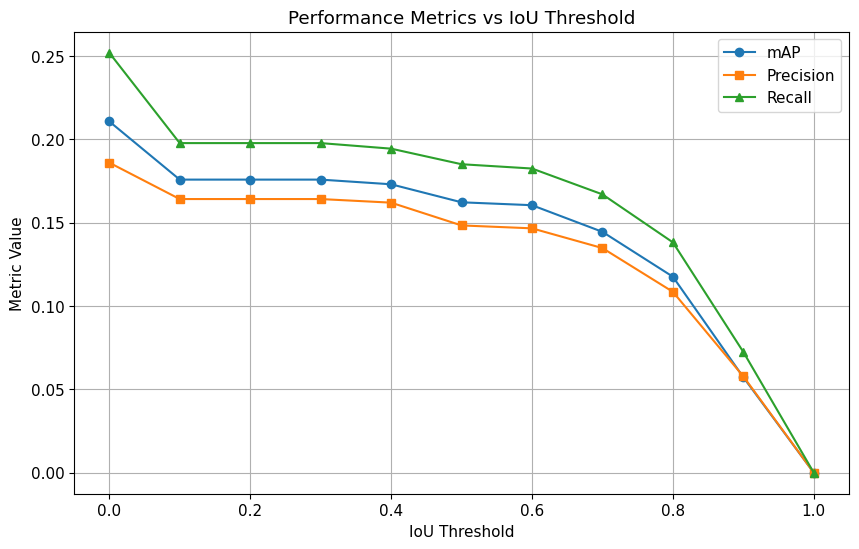

In [25]:
# --- Loop over dataset and compute metrics for different IoU thresholds ---
iou_thresholds_to_test = [threshold / 100 for threshold in range(0, 101, 10)]
results = {iou: {"mAP": [], "precision": [], "recall": []} for iou in iou_thresholds_to_test}

for idx in tqdm(range(len(dataset))):
    img, target = dataset[idx]
    img_tensor = transform(img)
    img_np = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    h0, w0 = img_np.shape[:2]
    img_l = letterbox(img_np, new_shape=(640, 640))
    r = min(640 / h0, 640 / w0)
    dw, dh = ((640 - int(w0 * r)) / 2, (640 - int(h0 * r)) / 2)
    img_tensor = torch.from_numpy(img_l).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        raw = yolo_model.model(img_tensor)
    dets_nms = non_max_suppression(raw, conf_thresh=0.25, iou_thresh=0.5)[0]
    if dets_nms.numel():
        pred_boxes = dets_nms[:, :4].clone()
        pred_scores = dets_nms[:, 4]
        pred_labels = dets_nms[:, 5].long()
        pred_boxes = scale_coords_pad(pred_boxes, (h0, w0))
    else:
        pred_boxes = torch.empty((0, 4))
        pred_scores = torch.empty((0,))
        pred_labels = torch.empty((0,), dtype=torch.int64)

    ann = target['annotation']['object']
    if not isinstance(ann, list):
        ann = [ann]
    gt_boxes = []
    gt_labels = []
    for obj in ann:
        bbox = obj['bndbox']
        x1 = float(bbox['xmin'])
        y1 = float(bbox['ymin'])
        x2 = float(bbox['xmax'])
        y2 = float(bbox['ymax'])
        gt_boxes.append([x1, y1, x2, y2])
        gt_labels.append(0)
    gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
    gt_labels = torch.tensor(gt_labels, dtype=torch.int64)

    for iou_threshold in iou_thresholds_to_test:
        map_iou = mean_average_precision(
            pred_boxes, pred_scores, pred_labels,
            gt_boxes, gt_labels,
            iou_threshold=iou_threshold
        )
        results[iou_threshold]["mAP"].append(map_iou)

        metrics = precision_recall_f1_at_thresholds(
            pred_boxes, pred_scores, pred_labels,
            gt_boxes, gt_labels,
            iou_thresholds=[iou_threshold]
        )
        p, r, _ = metrics[iou_threshold]
        results[iou_threshold]["precision"].append(p)
        results[iou_threshold]["recall"].append(r)

# --- Aggregate results ---
# plot
iou_thresholds = list(results.keys())
mean_maps = [torch.tensor(results[iou]["mAP"]).mean().item() for iou in iou_thresholds]
mean_precisions = [torch.tensor(results[iou]["precision"]).mean().item() for iou in iou_thresholds]
mean_recalls = [torch.tensor(results[iou]["recall"]).mean().item() for iou in iou_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, mean_maps, label="mAP", marker="o")
plt.plot(iou_thresholds, mean_precisions, label="Precision", marker="s")
plt.plot(iou_thresholds, mean_recalls, label="Recall", marker="^")
plt.xlabel("IoU Threshold")
plt.ylabel("Metric Value")
plt.title("Performance Metrics vs IoU Threshold")
plt.legend()
plt.grid(True)
plt.show()

### 7
(**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).

some experiments in task 6 - pascal dataset (2007) from pytorch

In [ ]:
# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1]) # ratio (new / old)
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r))) # new unpadded size
    dw = new_shape[1] - new_unpad[0] # width padding (left + right)
    dh = new_shape[0] - new_unpad[1] # height padding (top + bottom)
    dw /= 2 # divide padding into 2 sides
    dh /= 2 # divide padding into 2 sides
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR) # resize
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1)) # add padding to top and bottom
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1)) # add padding to left and right
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color) # add border
    return im

def get_raw(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image_np = np.array(image)  # Convert PIL image to NumPy array

    img_letterboxed = letterbox(image_np)
    img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0  # HWC → CHW and normalize
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Inference without NMS
    with torch.no_grad():
        raw_preds = yolo_model.model(img_tensor)  # tensor of shape [1, 25200, 85]

    return raw_preds

In [26]:
def experiment_image_url(URL, IOU=0.5, CONF=0.25, nms_function=non_max_suppression):
    # Download and get image
    resp = requests.get(URL)
    orig = np.array(Image.open(BytesIO(resp.content)).convert("RGB"))
    h0, w0 = orig.shape[:2]

    raw_preds = get_raw(URL)

    # Rescale boxes from padded image to original image
    def scale_coords_pad(boxes, old_size, new_size = (640, 640)):
        h0, w0 = old_size # original image size

        # calculate ratio and new unpadded size
        r = min(new_size[0] / h0, new_size[1] / w0) # ratio (new / old)
        new_unpad = (int(w0 * r), int(h0 * r)) # new unpadded size
        dw, dh = (new_size[1] - new_unpad[0]) / 2, (new_size[0] - new_unpad[1]) / 2 # padding (left + right, top + bottom)

        # remove padding
        boxes[:, [0,2]] -= dw
        boxes[:, [1,3]] -= dh
        # then scale back
        boxes[:, :4] /= r
        # clip to original
        boxes[:, 0].clamp_(0, w0) # x1
        boxes[:, 1].clamp_(0, h0) # y1
        return boxes


    # Prepare raw & NMS predictions (as before)
    preds = raw_preds[0] # extract first image predictions
    obj = preds[:, 4] # objectness score

    # Filter by confidence threshold
    cls_conf, cls_id = preds[:, 5:].max(1) # class confidence
    scores = obj * cls_conf # compute final score
    mask = scores > CONF # create mask for filtering
    raw_boxes_xywh = preds[mask, :4] # filter boxes and keep their xywh format
    raw_scores = scores[mask] # filter and keep scores
    raw_boxes = xywh2xyxy(raw_boxes_xywh) # convert to xyxy on padded
    raw_boxes = scale_coords_pad(raw_boxes, (h0, w0)) # rescale to original image

    # NMS output
    dets_nms = nms_function(raw_preds, conf_thresh=CONF, iou_thresh=IOU)
    out = dets_nms[0] if dets_nms and dets_nms[0].numel() else torch.empty((0,6)) # empty if no detections
    nms_boxes = out[:, :4].clone() # xyxy format
    nms_scores = out[:, 4] # confidence score
    nms_boxes = scale_coords_pad(nms_boxes, (h0, w0)) # rescale to original image

    # Draw and plot
    def draw_boxes(img, boxes, confs=None):
        im = img.copy()
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,0), 2)
            if confs is not None:
                cv2.putText(im, f"{confs[i]:.2f}", (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        return im

    fig, axes = plt.subplots(1,2, figsize=(12,6))
    axes[0].imshow(draw_boxes(orig, raw_boxes, raw_scores))
    axes[0].set_title(f"Raw preds (conf>{CONF})")
    axes[0].axis("off")

    axes[1].imshow(draw_boxes(orig, nms_boxes, nms_scores))
    axes[1].set_title(f"After NMS (IoU>{IOU})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


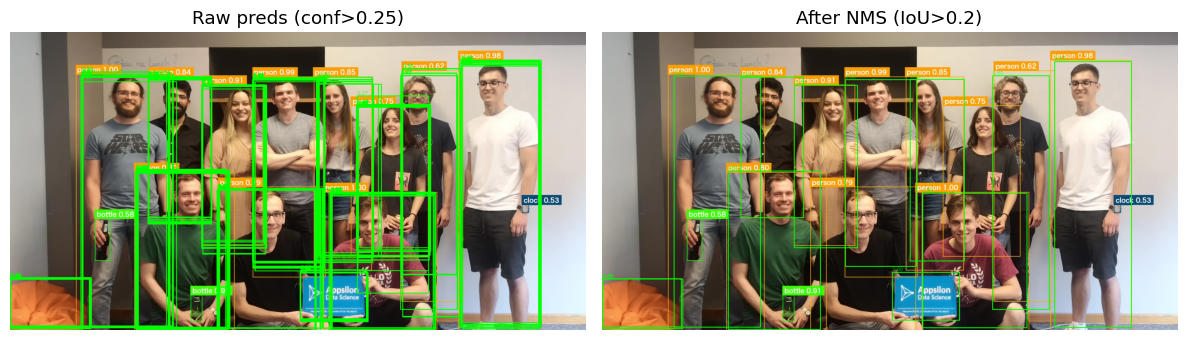

In [33]:
experiment_image_url("https://cdn.prod.website-files.com/654fd3ad88635290d9845b9e/65b39f55da88975b21ae6f33_6525256482c9e9a06c7a9d3c%252F65aab94b6509044d2c434fc8_appsilon_gathering_hero.webp", IOU=0.2)

### 8 (bonus points)
(**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?

In [36]:
def soft_non_max_suppression(predictions, conf_thresh=0.25, iou_thresh=0.5, sigma=0.5, max_detections=300):
    """
    Applies Soft Non-Maximum Suppression (Soft-NMS) on inference results.
    predictions: torch.Tensor of shape [batch, num_preds, 85]
    Returns list of detections per image [[x1, y1, x2, y2, conf, cls], ...]
    """
    output = []

    for preds in predictions:  # process each image
        # Compute confidence and filter
        conf = preds[:, 4]
        cls_scores, cls_inds = preds[:, 5:].max(1)
        confidences = conf * cls_scores
        mask = confidences > conf_thresh
        preds = preds[mask]
        confidences = confidences[mask]
        cls_inds = cls_inds[mask]

        # If none remain, add empty
        if not preds.size(0):
            output.append(torch.empty((0, 6)))
            continue

        # Convert boxes to xyxy
        boxes = xywh2xyxy(preds[:, :4])

        # Stack boxes, confidences, class
        dets = torch.cat((boxes, confidences.unsqueeze(1), cls_inds.float().unsqueeze(1)), dim=1)

        # Sort by confidence descending
        dets = dets[dets[:, 4].argsort(descending=True)]

        # Apply Soft-NMS
        keep = []
        while dets.size(0) and len(keep) < max_detections:
            # Select top detection
            top = dets[0]
            keep.append(top)

            if dets.size(0) == 1:
                break

            # Compute IoU of the top with the rest
            ious = box_iou(top[:4].unsqueeze(0), dets[:, :4])[0]

            # Update scores using Soft-NMS formula
            weights = torch.exp(-(ious ** 2) / sigma)
            dets[:, 4] *= weights

            # Remove detections with scores below the confidence threshold
            dets = dets[dets[:, 4] > conf_thresh]

        output.append(torch.stack(keep) if keep else torch.empty((0, 6)))

    return output

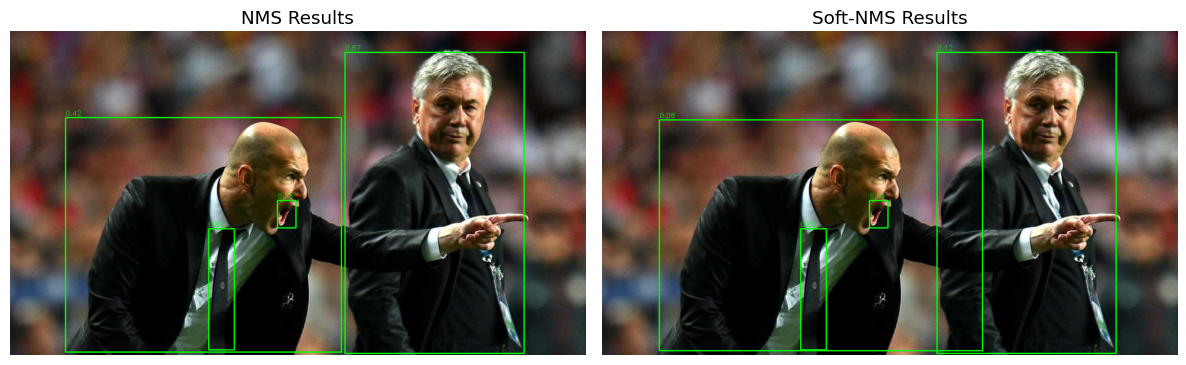

In [ ]:
def compare_nms_methods(image_url, conf_thresh=0.25, iou_thresh=0.5, sigma=0.5):
    # Download and preprocess the image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    orig = np.array(image)
    h0, w0 = orig.shape[:2]

    # Get raw predictions
    raw_preds = get_raw(image_url)

    # Apply NMS
    nms_results = non_max_suppression(raw_preds, conf_thresh=conf_thresh, iou_thresh=iou_thresh)
    nms_out = nms_results[0] if nms_results and nms_results[0].numel() else torch.empty((0, 6))
    nms_boxes = nms_out[:, :4].clone()
    nms_scores = nms_out[:, 4]
    nms_boxes = scale_coords_pad(nms_boxes, (h0, w0))

    # Apply Soft-NMS
    soft_nms_results = soft_non_max_suppression(raw_preds, conf_thresh=conf_thresh, iou_thresh=iou_thresh, sigma=sigma)
    soft_nms_out = soft_nms_results[0] if soft_nms_results and soft_nms_results[0].numel() else torch.empty((0, 6))
    soft_nms_boxes = soft_nms_out[:, :4].clone()
    soft_nms_scores = soft_nms_out[:, 4]
    soft_nms_boxes = scale_coords_pad(soft_nms_boxes, (h0, w0))

    # Draw and plot results
    def draw_boxes(img, boxes, confs=None):
        im = img.copy()
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
            if confs is not None:
                cv2.putText(im, f"{confs[i]:.2f}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        return im

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(draw_boxes(orig, nms_boxes, nms_scores))
    axes[0].set_title("NMS Results")
    axes[0].axis("off")

    axes[1].imshow(draw_boxes(orig, soft_nms_boxes, soft_nms_scores))
    axes[1].set_title("Soft-NMS Results")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

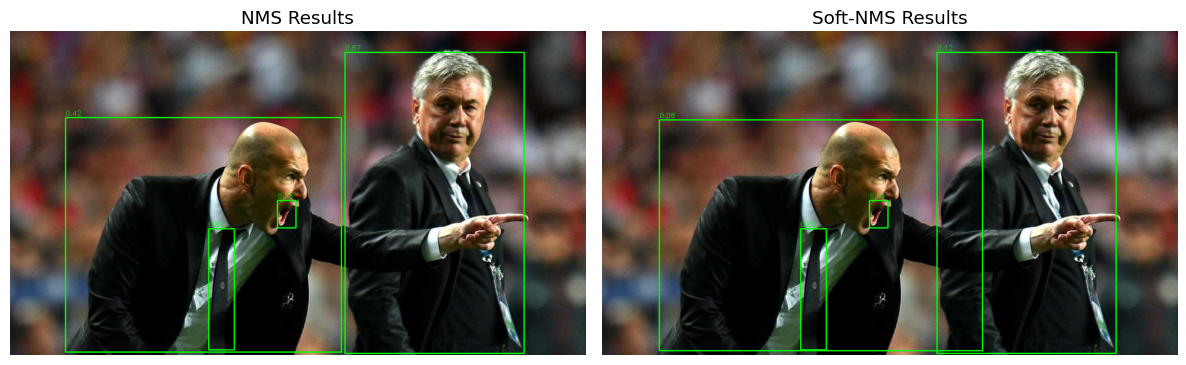

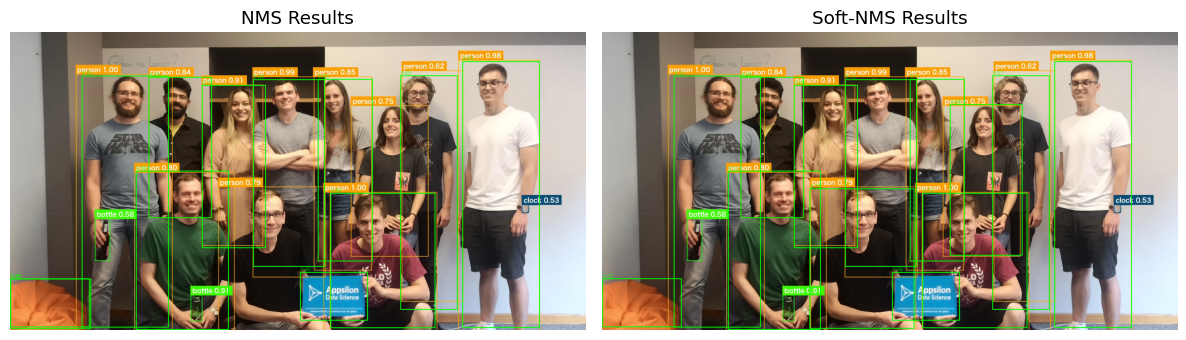

In [42]:
compare_nms_methods("https://ultralytics.com/images/zidane.jpg", conf_thresh=0.25, iou_thresh=0.01, sigma=0.5)
compare_nms_methods("https://cdn.prod.website-files.com/654fd3ad88635290d9845b9e/65b39f55da88975b21ae6f33_6525256482c9e9a06c7a9d3c%252F65aab94b6509044d2c434fc8_appsilon_gathering_hero.webp", iou_thresh=0.2)